In [1]:
%matplotlib inline
import utils; reload(utils)
from random import randint
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
path = 'data/fishes/'
full_path = os.getcwd() + '/' + path

In [3]:
batch_size = 64

In [4]:
VERSION = 'fcn_003'

In [5]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

### To do list:

1. Create validation set and sample
2. Move to separate dirs for each set
3. Finetune and train
4. Submit to kaggle

# Create validation set and sample

In [56]:
validation_ratio = 0.15
sample_ratio = 0.03

First, create the validation directory and move `validation_ratio` % to it

In [58]:
def create_validation_dir():
    os.mkdir(full_path + 'valid')
    for fish in classes:
        os.mkdir(full_path + 'valid/' + fish)
        fish_path = full_path + '{}/' + fish + '/'
        fish_train_path = fish_path.format('train')
        g = glob(fish_train_path + '*.jpg')
        g = np.random.permutation(g)
        elems = int(len(g) * validation_ratio)
        print(fish, 'size:', len(g), 'moving:', elems)
        for image in g[:elems]:    
            image_name = image.split('/')[-1]
            os.rename(image, fish_path.format('valid') + image_name)

In [59]:
def undo_validation_dir():
    for fish in classes:
        fish_path = full_path + '{}/' + fish + '/'
        fish_valid_path = fish_path.format('valid')
        g = glob(fish_valid_path + '*.jpg')
        for image in g:    
            image_name = image.split('/')[-1]
            os.rename(image, fish_path.format('train') + image_name)
        os.rmdir(fish_valid_path)
    os.rmdir(full_path + 'valid')

In [60]:
from shutil import copy, rmtree

In [61]:
def create_sample_dir():
    os.mkdir(full_path + 'sample')
    os.mkdir(full_path + 'sample/valid')
    os.mkdir(full_path + 'sample/train')
    for fish in classes:
        os.mkdir(full_path + 'sample/valid/' + fish)
        os.mkdir(full_path + 'sample/train/' + fish)

        fish_path = full_path + '{}/' + fish + '/'
        fish_train_path = fish_path.format('train')
        g = glob(fish_train_path + '*.jpg')
        elems_train = min(int(len(g) * sample_ratio), 3)
        elems_valid = min(int(len(g) * validation_ratio * sample_ratio), 3)
        for image in g[:elems_train]:    
            image_name = image.split('/')[-1]
            copy(image, fish_path.format('sample/train') + image_name)
        for image in g[:elems_valid]:    
            image_name = image.split('/')[-1]
            copy(image, fish_path.format('sample/valid') + image_name)
            
def remove_sample_dir():
    rmtree(full_path + 'sample')

In [62]:
#undo_validation_dir()
#create_validation_dir()


In [63]:
#create_sample_dir()
# remove_sample_dir()

Then, create the sample directory (with subdirs `train` and `valid`) and __copy__ a small set 

# Fully conv net (FCN)

In [5]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 3214 images belonging to 8 classes.
Found 563 images belonging to 8 classes.
Found 3214 images belonging to 8 classes.
Found 563 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


First, get the data in our desired format

In [17]:
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

Found 3214 images belonging to 8 classes.
Found 563 images belonging to 8 classes.


In [19]:
test = get_data(path + 'test', (360, 640))

Found 1000 images belonging to 1 classes.


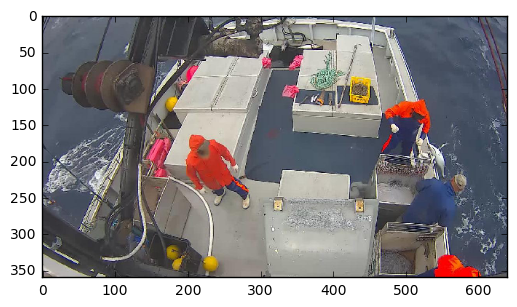

In [18]:
plot(trn[0])

In [20]:
save_array(path+'results/trn_640.dat', trn)
save_array(path+'results/val_640.dat', val)

In [21]:
save_array(path+'results/test_640.dat', test)

In [11]:
trn = load_array(path+'results/trn_640.dat')
val = load_array(path+'results/val_640.dat')
test = load_array(path+'results/test_640.dat')

In [13]:
vgg640 = Vgg16BN((360, 640)).model
vgg640 = Vgg16BN().model

In [14]:
vgg640.pop()  # Remove the las maxpooling layer
vgg640.input_shape, vgg640.output_shape

((None, 3, 224, 224), (None, 4096))

In [15]:
vgg640.compile(
    Adam(),
    'categorical_crossentropy',
    metrics=['accuracy'])

In [16]:
conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

NameError: name 'val' is not defined

In [45]:
save_array(path+'results/conv_val_640.dat', conv_val_feat)
save_array(path+'results/conv_trn_640.dat', conv_trn_feat)

In [27]:
conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

1000/1000 [==============================] - 129s   


In [28]:
save_array(path+'results/conv_test_640.dat', conv_test_feat)

In [14]:
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')

In [15]:
conv_test_feat = load_array(path+'results/conv_test_640.dat')

Generate the new CNN part

In [17]:
conv_layers, _ = split_at(vgg640, Convolution2D)

In [18]:
nf = 128
p  = 0

In [19]:
def get_lrg_layers_1():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),

        Convolution2D(256, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        
        Convolution2D(128, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        
        Convolution2D(64, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        
        Convolution2D(8, 3, 3, border_mode='same'),
        
        # Output layer
        GlobalAveragePooling2D(),
        Activation('softmax'),
    ]

In [20]:
my_model = Sequential(get_lrg_layers_1())

th


In [21]:
my_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_7 (BatchNormal(None, 512, 14, 14)   1024        batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
convolution2d_44 (Convolution2D) (None, 256, 14, 14)   1179904     batchnormalization_7[0][0]       
____________________________________________________________________________________________________
batchnormalization_8 (BatchNormal(None, 256, 14, 14)   512         convolution2d_44[0][0]           
____________________________________________________________________________________________________
maxpooling2d_19 (MaxPooling2D)   (None, 256, 7, 7)     0           batchnormalization_8[0][0]       
___________________________________________________________________________________________

In [22]:
my_model.compile(
    Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
conv_val_feat.shape

In [29]:
my_model.fit(
    conv_trn_feat,
    trn_labels,
    batch_size=batch_size,
    nb_epoch=2,
    validation_data=(conv_val_feat, val_labels))

Train on 3214 samples, validate on 563 samples
Epoch 1/2
3214/3214 [==============================] - 15s - loss: 0.6249 - acc: 0.8030 - val_loss: 1.6466 - val_acc: 0.6963
Epoch 2/2
3214/3214 [==============================] - 15s - loss: 0.1015 - acc: 0.9736 - val_loss: 0.3888 - val_acc: 0.9076


In [30]:
my_model.optimizer.lr = 1e-5

In [31]:
my_model.fit(
    conv_trn_feat,
    trn_labels,
    batch_size=batch_size,
    nb_epoch=7,
    validation_data=(conv_val_feat, val_labels))

Train on 3214 samples, validate on 563 samples
Epoch 1/7
3214/3214 [==============================] - 15s - loss: 0.0359 - acc: 0.9919 - val_loss: 0.3316 - val_acc: 0.8988
Epoch 2/7
3214/3214 [==============================] - 15s - loss: 0.0453 - acc: 0.9904 - val_loss: 0.3116 - val_acc: 0.9130
Epoch 3/7
3214/3214 [==============================] - 15s - loss: 0.0300 - acc: 0.9919 - val_loss: 0.2042 - val_acc: 0.9467
Epoch 4/7
3214/3214 [==============================] - 15s - loss: 0.0100 - acc: 0.9978 - val_loss: 0.1668 - val_acc: 0.9503
Epoch 5/7
3214/3214 [==============================] - 15s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.1557 - val_acc: 0.9538
Epoch 6/7
3214/3214 [==============================] - 15s - loss: 7.9246e-04 - acc: 1.0000 - val_loss: 0.1364 - val_acc: 0.9645
Epoch 7/7
3214/3214 [==============================] - 15s - loss: 0.0017 - acc: 0.9994 - val_loss: 0.1666 - val_acc: 0.9556


In [32]:
my_model.save_weights(path+'models/lrg_nmp{}.h5'.format(VERSION))

In [23]:
my_model.load_weights(path+'models/lrg_nmp{}.h5'.format(VERSION))

In [24]:
my_model.evaluate(conv_val_feat, val_labels)

563/563 [==============================] - 1s     


[0.16664165235682826, 0.95559502664298401]

# Making heatmaps

In [37]:
l = my_model.layers
conv_fn = K.function(
    [l[0].input, K.learning_phase()],
    l[-3].output)

In [38]:
def get_cm(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

In [56]:
inp = np.expand_dims(conv_val_feat[3], 0)
np.round(my_model.predict(inp)[0],2)

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

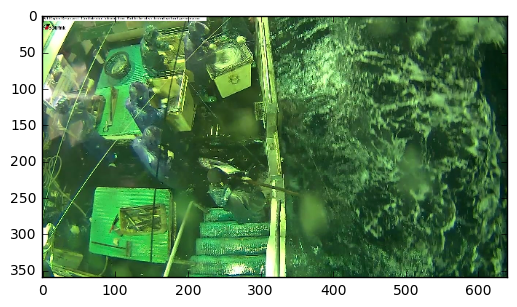

In [57]:
plt.imshow(to_plot(val[3]))

In [61]:
cm = get_cm(inp, 0)

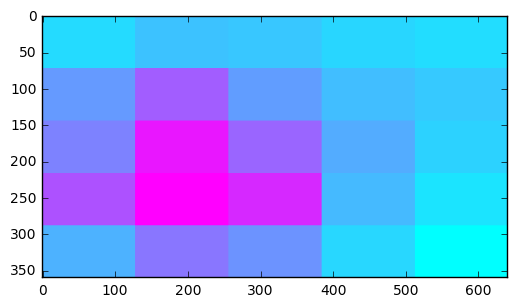

In [62]:
plt.imshow(cm, cmap='cool')

# Submit

In [25]:
test = load_array(path+'results/test.dat')

In [28]:
#test_batches = get_batches(path + 'test', shuffle=False)
preds = my_model.predict(conv_test_feat, batch_size=batch_size)

In [29]:
def do_clip(arr, mx):
    return np.clip(arr, (1-mx)/7, mx)

In [30]:
subm = do_clip(preds, 0.85)
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]


In [31]:
subm_name = path+'results/subm_bb_dp_{}.gz'.format(VERSION)

In [34]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_06237.jpg,0.850000,0.021429,0.021429,0.021429,0.021429,0.021429,0.021429,0.021429
1,img_06893.jpg,0.065809,0.021429,0.021429,0.021429,0.021429,0.850000,0.021429,0.024302
2,img_02082.jpg,0.176916,0.021429,0.021429,0.021429,0.820871,0.021429,0.021429,0.021429
3,img_06261.jpg,0.850000,0.021429,0.021429,0.021429,0.021429,0.021429,0.021429,0.021429
4,img_03628.jpg,0.850000,0.021429,0.021429,0.021429,0.021429,0.021429,0.021429,0.021429


In [35]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [36]:
FileLink(subm_name)

/home/ubuntu/nbs/data/fishes/results/subm_bb_dp_fcn_003.gz